C:\Users\wzzha\AppData\Local\Temp\ipykernel_10796\2000634976.py:273: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / freqs
c:\Users\wzzha\miniconda3\envs\futu_trends\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


       trend_length  direction                       end_date
count     53.000000  53.000000                             53
mean       8.830189   0.169811  2023-05-13 11:19:14.716981248
min        5.000000  -1.000000            2021-05-19 00:00:00
25%        6.000000  -1.000000            2022-05-03 00:00:00
50%        7.000000   1.000000            2023-06-09 00:00:00
75%       11.000000   1.000000            2024-06-24 00:00:00
max       29.000000   1.000000            2025-05-09 00:00:00
std        4.814784   0.994907                            NaN


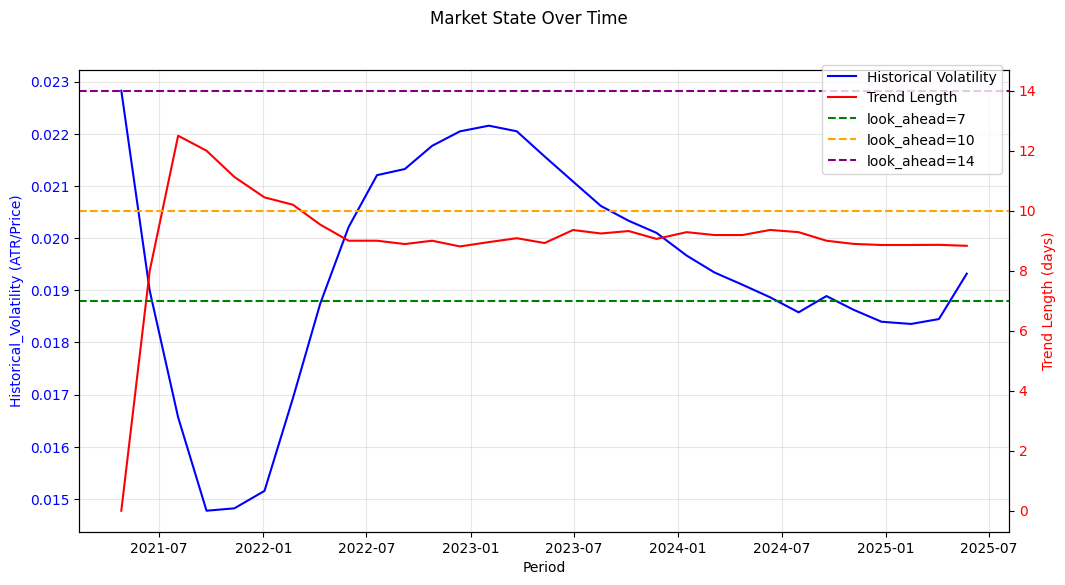

In [72]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from hyperopt import hp, fmin, tpe, Trials
from IPython.display import display
from statsmodels.tsa.stattools import acf
from scipy.signal import periodogram
import os

# 设置随机种子
random_seed = 42  # 可以选择任意整数（如 42、2025 等）
np.random.seed(random_seed)
random.seed(random_seed)

# 数据文件路径
data_dir = '../data'
csv_filename = 'data_US_QQQ_20250525_K_DAY.csv'
csv_path = os.path.join(data_dir, csv_filename)

# 读取本地CSV文件
df = pd.read_csv(csv_path, index_col=0, parse_dates=True)

# ATR计算（矢量化）
def ATR(high, low, close, period=14):
    tr = pd.DataFrame(index=high.index)
    tr['HL'] = high - low
    tr['HC'] = abs(high - close.shift(1))
    tr['LC'] = abs(low - close.shift(1))
    tr['TR'] = tr[['HL', 'HC', 'LC']].max(axis=1)
    return tr['TR'].rolling(window=int(period), min_periods=1).mean()

# Numba加速未来范围计算
@njit
def get_future_range_numba(series, look_ahead, is_high=True):
    future_values = np.full(len(series), np.nan)
    for i in range(len(series) - look_ahead):
        if is_high:
            future_values[i] = np.max(series[i+1:i+1+look_ahead])
        else:
            future_values[i] = np.min(series[i+1:i+1+look_ahead])
    return future_values

def calculate_trend_duration(df, min_trend_days=5):
    """
    使用均线理论计算趋势长度，以趋势终结日期为索引
    
    参数:
    - min_trend_days: 最小趋势天数
    
    返回:
    - DataFrame包含趋势信息：trend_length, direction
    - 索引为趋势终结日期
    """
    # 计算均线
    df = df.copy()
    df['ma_short'] = df['close'].rolling(window=5).mean()
    df['ma_middle'] = df['close'].rolling(window=10).mean()
    df['ma_long'] = df['close'].rolling(window=15).mean()
    
    trends_data = []
    current_trend = {
        'direction': 0,  # 1: 上升, -1: 下降
        'days': 0,
    }
    
    for i in range(15, len(df)):
        today = df.index[i]
        # 判断趋势方向
        is_uptrend = (df['ma_short'].iloc[i] > df['ma_middle'].iloc[i] > df['ma_long'].iloc[i] and
                     df['ma_short'].iloc[i] > df['ma_short'].iloc[i-1])
        is_downtrend = (df['ma_short'].iloc[i] < df['ma_middle'].iloc[i] < df['ma_long'].iloc[i] and
                       df['ma_short'].iloc[i] < df['ma_short'].iloc[i-1])
        
        if current_trend['direction'] == 0:  # 新趋势开始
            if is_uptrend:
                current_trend = {
                    'direction': 1,
                    'days': 1,
                }
            elif is_downtrend:
                current_trend = {
                    'direction': -1,
                    'days': 1,
                }
        else:  # 已有趋势
            if (current_trend['direction'] == 1 and is_uptrend) or \
               (current_trend['direction'] == -1 and is_downtrend):
                # 趋势继续
                current_trend['days'] += 1
            else:
                # 趋势结束
                if current_trend['days'] >= min_trend_days:
                    trends_data.append({
                        'trend_length': current_trend['days'],
                        'direction': current_trend['direction'],
                        'end_date': today
                    })
                # 重置趋势
                current_trend = {
                    'direction': 0,
                    'days': 0,
                }
    
    # 转换为DataFrame，使用趋势终结日期作为索引
    trends_df = pd.DataFrame(trends_data, index=[trend['end_date'] for trend in trends_data])
    
    # 丢弃首尾趋势
    if len(trends_df) > 2:
        trends_df = trends_df.iloc[1:-1]
    
    return trends_df

# 按时间段分析市场状态
def analyze_market_states(df, period=21):
    df = df.copy()
    # df['date'] = df.index
    group_count = np.ceil(len(df) / period)
    grouped = np.array_split(df, group_count)
    
    volatility = []
    historical_volatility = []
    trend_length = []
    periods = []
    
    # 预先计算全局趋势
    trends_df = calculate_trend_duration(df)
    print(trends_df.describe())
    
    for i, group in enumerate(grouped):
        name = group.index[-1]
        atr = ATR(group['high'], group['low'], group['close'], period=period)
        vol = atr.mean() / group['close'].mean()
        volatility.append(vol)
        
        # 获取当前分组最后一天之前的所有趋势
        group_end = group.index[-1]
        historical_trends = trends_df[trends_df.index <= group_end]['trend_length'].values
        
        # 计算历史趋势长度
        if len(historical_trends) > 0:
            trend_median = np.mean([f for f in historical_trends if f > 0])
            trend_length.append(trend_median)
        else:
            trend_length.append(0)

        historical_volatility.append(np.mean(volatility))
        periods.append(name)
    
    return pd.DataFrame({
        'Period': periods,
        'Volatility': volatility,
        'Historical_Volatility': historical_volatility,
        'Trend_Length': trend_length
    })

# 绘制状态图表
def plot_market_states(df_states):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # 波动性（左轴）
    ax1.plot(df_states['Period'], df_states['Historical_Volatility'], color='blue', label='Historical Volatility')
    ax1.set_xlabel('Period')
    ax1.set_ylabel('Historical_Volatility (ATR/Price)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True, alpha=0.3)
    
    # 趋势长度（右轴）
    ax2 = ax1.twinx()
    ax2.plot(df_states['Period'], df_states['Trend_Length'], color='red', label='Trend Length')
    ax2.set_ylabel('Trend Length (days)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # 添加参考线
    ax2.axhline(7, color='green', linestyle='--', label='look_ahead=7')
    ax2.axhline(10, color='orange', linestyle='--', label='look_ahead=10')
    ax2.axhline(14, color='purple', linestyle='--', label='look_ahead=14')
    
    fig.suptitle('Market State Over Time')
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
    plt.show()

# 趋势持续时间分布
def plot_trend_duration_distribution(df, smooth_window=5):
    if len(df) <= smooth_window:
        print('df length is less than smooth_window')
        return 0, 0

    trends = calculate_trend_duration(df, smooth_window)
    
    if len(trends) <= 1:
        print('trends length is less than 1')
        return 0, 0
    mean_duration = np.mean(trends['trend_length'].values) 
    median_duration = np.median(trends['trend_length'].values)

    plt.figure(figsize=(10, 6))
    plt.hist(trends['trend_length'], bins=30, color='blue', alpha=0.7, label='Trend Duration Distribution')
    plt.axvline(mean_duration, color='red', linestyle='--', label=f'Mean: {mean_duration:.1f} days')
    plt.axvline(median_duration, color='green', linestyle='--', label=f'Median: {median_duration:.1f} days')
    plt.title(f'Trend Duration Distribution (smooth_window={smooth_window})')
    plt.xlabel('Duration (days)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return mean_duration, median_duration

def determine_look_ahead(volatility, trend_length):
    # look_ahead简洁参考规则
    # 规则 1：根据波动性和趋势长度选择 look_ahead
    # 高波动 + 短趋势（震荡行情）：
    # 波动性 > 0.03，且趋势长度 < 7 天。
    # 推荐 look_ahead：7 天。
    # 理由：捕捉快速顶底，信号密集，适合每周 2-3 次（每月 ≈ 10-15 次）。
    # 适用标的：高波动个股（如科技股）、震荡期指数。
    # 低波动 + 长趋势（趋势行情）：
    # 波动性 < 0.02，且趋势长度 > 10 天。
    # 推荐 look_ahead：14 天。
    # 理由：减少无效信号，确认趋势反转，信号频率降低（每月 ≈ 5-10 次）。
    # 适用标的：低波动指数（如蓝筹股指数）、趋势期市场。
    # 中等波动 + 中等趋势（混合行情）：
    # 波动性 0.02-0.03，或趋势长度 7-10 天。
    # 推荐 look_ahead：10 天。
    # 理由：平衡胜率和召回率，信号频率适中（每月 ≈ 7-12 次）。
    # 适用标的：中波动指数（如上证综指）、混合期市场。
    # 规则 2：调整信号频率
    # 如果信号频率过高（每月 > 15 次）：
    # 增加 strength_threshold（如 0.1 → 0.2），减少信号数量。
    # 或缩短 atr_period_explicit 和 atr_period_hidden（如 45 → 20），提高信号质量。
    # 如果信号频率过低（每月 < 5 次）：
    # 降低 strength_threshold（如 0.2 → 0.1），增加信号数量。
    # 或延长 look_ahead（如 7 → 10），捕捉更多反转。
    # 规则 3：通用性扩展
    # 高波动标的（个股或高风险资产）：
    # 默认波动性阈值可放宽（> 0.04 算高波动），趋势长度阈值缩短（< 5 天）。
    # 低波动标的（债券指数或稳定资产）：
    # 默认波动性阈值收紧（< 0.015 算低波动），趋势长度阈值延长（> 12 天）。
    # 调整范围：
    # 波动性范围：0.01-0.06（灵活调整）。
    # 趋势长度范围：3-20 天（根据分布调整）。
    if volatility > 0.03 and trend_length < 7:
        return 7
    elif volatility < 0.02 and trend_length > 10:
        return 14
    else:
        return 10

# 测试不同参数
# for smooth_window in [5, 10, 20, 30, 60]:
#     for min_return in [0]:
#         mean_duration, median_duration = plot_trend_duration_distribution(df, smooth_window)
#         print(f"smooth_window={smooth_window}, Mean={mean_duration:.1f}, Median={median_duration:.1f}")

def calculate_target_multiplier(df, atr_period=20, look_ahead=10):
    df = df.copy()
    atr = ATR(df['high'], df['low'], df['close'], period=atr_period)
    df['atr'] = atr
    df['future_high'] = get_future_range_numba(df['high'].values, look_ahead, is_high=True)
    df['future_low'] = get_future_range_numba(df['low'].values, look_ahead, is_high=False)
    
    support_returns = (df['future_high'] - df['close']) / df['atr']
    resistance_returns = (df['close'] - df['future_low']) / df['atr']
    valid_returns = pd.concat([support_returns.dropna(), resistance_returns.dropna()])
    
    return np.median(valid_returns) if len(valid_returns) > 0 else 1.0

def calculate_atr_period(df, max_period=60):
    daily_range = df['high'] - df['low']
    freqs, power = periodogram(daily_range.dropna())
    periods = 1 / freqs
    valid_idx = np.where((periods > 5) & (periods <= max_period))
    dominant_period = periods[valid_idx][np.argmax(power[valid_idx])]
    return int(dominant_period) if dominant_period else 36

def get_signal_target_percentage(volatility):
    if volatility > 0.03:
        return 0.07  # 震荡行情，信号密集
    elif volatility < 0.01:
        return 0.03  # 趋势行情，信号稀疏
    else:
        return 0.05  # 混合行情，适中

# 随机指标计算（矢量化）
def Stochastic(high, low, close, k_period, d_period):
    low_min = low.rolling(window=int(k_period), min_periods=1).min()
    high_max = high.rolling(window=int(k_period), min_periods=1).max()
    k = 100 * (close - low_min) / (high_max - low_min)
    d = k.rolling(window=int(d_period), min_periods=1).mean()
    return k, d

# 主流atr_period
atr_period = calculate_atr_period(df)
# 分析市场状态
df_states = analyze_market_states(df, period=atr_period)
plot_market_states(df_states)
# 最近市场状态
current_state = df_states.iloc[-1]
currnet_look_ahead = determine_look_ahead(current_state['Historical_Volatility'], current_state['Trend_Length'])
look_ahead = currnet_look_ahead # 根据近期Trend Duration Distribution估计
target_multiplier = calculate_target_multiplier(df, atr_period=atr_period, look_ahead=look_ahead)

# 根据市场状态调整目标百分比
signal_target_percentage = get_signal_target_percentage(current_state['Historical_Volatility'])
signal_count_target = len(df) * signal_target_percentage

# 矢量化信号检测，区分显性和隐秘强信号
def detect_stochastic_signals_origin(df, k_period=14, d_period=3, overbought=55, oversold=45, ma_period=20,atr_period_explicit=14, atr_period_hidden=14, strength_threshold=2, mode='train'):
    df = df.copy()
    k, d = Stochastic(df['high'], df['low'], df['close'], k_period, d_period)
    df['k'] = k
    df['d'] = d
    ma = df['close'].rolling(window=int(ma_period), min_periods=1).mean()
    atr_explicit = ATR(df['high'], df['low'], df['close'], period=atr_period_explicit)
    atr_hidden = ATR(df['high'], df['low'], df['close'], period=atr_period_hidden)
    
    df['signal_strength'] = abs(k - d)
    df['k_amplitude'] = df['high'] - df['low']

    support_condition = (k > d) & (k.shift(1) <= d.shift(1)) & (k < oversold) & (df['close'] <= ma)
    resistance_condition = (k < d) & (k.shift(1) >= d.shift(1)) & (k > overbought) & (df['close'] >= ma)

    if mode == 'eval':
        # 推理考虑未来阳线
        # support_condition = (k > d) & (k.shift(1) <= d.shift(1)) & (k < oversold) & ((ma_short < ma_middle) & (ma_middle < ma_long)) & (df['close'] < support_ma) & ((df['close'].shift(-1) > df['close']) | (df['open'].shift(-1) < df['close'].shift(-1)))
        # resistance_condition = (k < d) & (k.shift(1) >= d.shift(1)) & (k > overbought) & ((ma_short > ma_middle) & (ma_middle > ma_long)) & (df['close'] > resistance_ma) & ((df['close'].shift(-1) < df['close']) | (df['open'].shift(-1) > df['close'].shift(-1)))
        support_condition = support_condition & (((df['close'].shift(-1) > df['close'])&(df['open'].shift(-1) < df['close'].shift(-1))) | ((df['close'] < df['close'].shift(-2))&(df['close'].shift(-1) < df['close'].shift(-2))))
        resistance_condition = resistance_condition & (((df['close'].shift(-1) < df['close'])&(df['open'].shift(-1) > df['close'].shift(-1))) | ((df['close'] > df['close'].shift(-2))&(df['close'].shift(-1) > df['close'].shift(-2))))
    elif mode == 'train':
        # 训练无未来函数
        pass

    df['reversal'] = np.select(
        [support_condition, resistance_condition],
        ['support reversal', 'resistance reversal'],
        default='none'
    )
    
    # 显性强信号 放量突破
    df['is_strong_explicit'] = np.where(
        (df['reversal'] != 'none') &
        (df['k_amplitude'] > atr_explicit) & 
        (df['signal_strength'] >= strength_threshold),
        1, 0
    )
    
    # 隐秘强信号 小实体衰竭
    df['is_strong_hidden'] = np.where(
        (df['reversal'] != 'none') & 
        (df['k_amplitude'] < atr_hidden) &
        (df['signal_strength'] >= strength_threshold),
        1, 0
    )
    
    df['is_strong'] = np.where(
        (df['is_strong_explicit'] == 1) | (df['is_strong_hidden'] == 1),
        1, 0
    )
    
    return df

def detect_stochastic_signals(df, k_sup=14, d_sup=3, k_res=14, d_res=3, overbought=55, oversold=45, support_ma_period=20, resistance_ma_period=20,atr_support_explicit=14, atr_support_hidden=14,atr_resistance_explicit=14, atr_resistance_hidden=14, support_threshold=2, resistance_threshold=2, mode='train'):
    df = df.copy()
    k_support, d_support = Stochastic(df['high'], df['low'], df['close'], k_sup, d_sup)
    k_resistance, d_resistance = Stochastic(df['high'], df['low'], df['close'], k_res, d_res)
    df['k_support'] = k_support
    df['d_support'] = d_support
    df['k_resistance'] = k_resistance
    df['d_resistance'] = d_resistance
    support_ma = df['close'].rolling(window=int(support_ma_period), min_periods=1).mean()
    resistance_ma = df['close'].rolling(window=int(resistance_ma_period), min_periods=1).mean()
    # atr_explicit = ATR(df['high'], df['low'], df['close'], period=atr_period_explicit)
    # atr_hidden = ATR(df['high'], df['low'], df['close'], period=atr_period_hidden)
    atr_explicit_support = ATR(df['high'], df['low'], df['close'], period=atr_support_explicit)
    atr_hidden_support = ATR(df['high'], df['low'], df['close'], period=atr_support_hidden)
    atr_explicit_resistance = ATR(df['high'], df['low'], df['close'], period=atr_resistance_explicit)
    atr_hidden_resistance = ATR(df['high'], df['low'], df['close'], period=atr_resistance_hidden)
    
    df['k_amplitude'] = df['high'] - df['low']

    support_condition = (k_support > d_support ) & (k_support.shift(1) <= d_support.shift(1)) & (k_support < oversold) & (df['close'] < support_ma)
    resistance_condition = (k_resistance < d_resistance) & (k_resistance.shift(1) >= d_resistance.shift(1)) & (k_resistance > overbought) & (df['close'] > resistance_ma)

    if mode == 'eval':
        # 推理考虑未来阳线
        # support_condition = (k > d) & (k.shift(1) <= d.shift(1)) & (k < oversold) & ((ma_short < ma_middle) & (ma_middle < ma_long)) & (df['close'] < support_ma) & ((df['close'].shift(-1) > df['close']) | (df['open'].shift(-1) < df['close'].shift(-1)))
        # resistance_condition = (k < d) & (k.shift(1) >= d.shift(1)) & (k > overbought) & ((ma_short > ma_middle) & (ma_middle > ma_long)) & (df['close'] > resistance_ma) & ((df['close'].shift(-1) < df['close']) | (df['open'].shift(-1) > df['close'].shift(-1)))
        support_condition = support_condition & (((df['close'].shift(-1) > df['close'])&(df['open'].shift(-1) < df['close'].shift(-1))) | ((df['close'] < df['close'].shift(-2))&(df['close'].shift(-1) < df['close'].shift(-2))))
        resistance_condition = resistance_condition & (((df['close'].shift(-1) < df['close'])&(df['open'].shift(-1) > df['close'].shift(-1))) | ((df['close'] > df['close'].shift(-2))&(df['close'].shift(-1) > df['close'].shift(-2))))
    elif mode == 'train':
        # 训练无未来函数
        pass

    df['reversal'] = np.select(
        [support_condition, resistance_condition],
        ['support reversal', 'resistance reversal'],
        default='none'
    )

    def calculate_signal_strength(row):
        if row['reversal'] =='support reversal':
            return abs(row['k_support'] - row['d_support'])
        elif row['reversal'] == 'resistance reversal':
            return abs(row['k_resistance'] - row['d_resistance'])
        else:
            return 0

    df['signal_strength'] = df.apply(calculate_signal_strength, axis=1)
    
    # 显性强信号 放量突破
    df['is_strong_explicit'] = np.where(
        ((df['reversal'] == 'support reversal') &
        (df['k_amplitude'] > atr_explicit_support) & 
        (df['signal_strength'] >= support_threshold)) |
        ((df['reversal'] == 'resistance reversal') &
        (df['k_amplitude'] < atr_explicit_resistance) & 
        (df['signal_strength'] >= resistance_threshold)),
        1, 0
    )
    
    # 隐秘强信号 小实体衰竭
    df['is_strong_hidden'] = np.where(
        ((df['reversal'] == 'support reversal') &
        (df['k_amplitude'] < atr_hidden_support) &
        (df['signal_strength'] >= support_threshold)) |
        ((df['reversal'] == 'resistance reversal') &
        (df['k_amplitude'] < atr_hidden_resistance) &
        (df['signal_strength'] >= resistance_threshold)),
        1, 0
    )
    
    df['is_strong'] = np.where(
        (df['is_strong_explicit'] == 1) | (df['is_strong_hidden'] == 1),
        1, 0
    )
    
    return df

def calculate_win_rate(df, look_ahead=10, target_multiplier=1, atr_period=20):
    df = df.copy()
    df['atr'] = ATR(df['high'], df['low'], df['close'], period=atr_period)
    
    df['support_target'] = df['close'] + df['atr'] * target_multiplier
    df['resistance_target'] = df['close'] - df['atr'] * target_multiplier
    
    df['future_high'] = get_future_range_numba(df['high'].values, look_ahead, is_high=True)
    df['future_low'] = get_future_range_numba(df['low'].values, look_ahead, is_high=False)

    df['recent_high'] = df['high'].rolling(window=3, min_periods=1).max()
    df['recent_low'] = df['low'].rolling(window=3, min_periods=1).min()
    
    df['support_win'] = np.where(
        (df['reversal'] == 'support reversal') & (df['future_high'] >= df['support_target']) & (df['recent_low'] <= df['future_low']),
        1, 0
    )
    df['resistance_win'] = np.where(
        (df['reversal'] == 'resistance reversal') & (df['future_low'] <= df['resistance_target']) & (df['recent_high'] >= df['future_high']),
        1, 0
    )
    
    support_signals = df[df['reversal'] == 'support reversal']
    resistance_signals = df[df['reversal'] == 'resistance reversal']
    support_win_rate = support_signals['support_win'].mean() if len(support_signals) > 0 else 0
    resistance_win_rate = resistance_signals['resistance_win'].mean() if len(resistance_signals) > 0 else 0
    
    strong_support_signals = df[(df['reversal'] == 'support reversal') & (df['is_strong'] == 1)]
    strong_resistance_signals = df[(df['reversal'] == 'resistance reversal') & (df['is_strong'] == 1)]
    strong_support_win_rate = strong_support_signals['support_win'].mean() if len(strong_support_signals) > 0 else 0
    strong_resistance_win_rate = strong_resistance_signals['resistance_win'].mean() if len(strong_resistance_signals) > 0 else 0
    
    explicit_strong_support_signals = df[(df['reversal'] == 'support reversal') & (df['is_strong_explicit'] == 1)]
    explicit_strong_resistance_signals = df[(df['reversal'] == 'resistance reversal') & (df['is_strong_explicit'] == 1)]
    explicit_strong_support_win_rate = explicit_strong_support_signals['support_win'].mean() if len(explicit_strong_support_signals) > 0 else 0
    explicit_strong_resistance_win_rate = explicit_strong_resistance_signals['resistance_win'].mean() if len(explicit_strong_resistance_signals) > 0 else 0
    
    hidden_strong_support_signals = df[(df['reversal'] == 'support reversal') & (df['is_strong_hidden'] == 1)]
    hidden_strong_resistance_signals = df[(df['reversal'] == 'resistance reversal') & (df['is_strong_hidden'] == 1)]
    hidden_strong_support_win_rate = hidden_strong_support_signals['support_win'].mean() if len(hidden_strong_support_signals) > 0 else 0
    hidden_strong_resistance_win_rate = hidden_strong_resistance_signals['resistance_win'].mean() if len(hidden_strong_resistance_signals) > 0 else 0
    
    support_recall = len(strong_support_signals) / len(support_signals) if len(support_signals) > 0 else 0
    resistance_recall = len(strong_resistance_signals) / len(resistance_signals) if len(resistance_signals) > 0 else 0
    
    return {
        'support_win_rate': support_win_rate,
        'support_signals_count': len(support_signals),
        'resistance_win_rate': resistance_win_rate,
        'resistance_signals_count': len(resistance_signals),
        'strong_support_win_rate': strong_support_win_rate,
        'strong_support_signals_count': len(strong_support_signals),
        'strong_resistance_win_rate': strong_resistance_win_rate,
        'strong_resistance_signals_count': len(strong_resistance_signals),
        'explicit_strong_support_win_rate': explicit_strong_support_win_rate,
        'explicit_strong_support_signals_count': len(explicit_strong_support_signals),
        'explicit_strong_resistance_win_rate': explicit_strong_resistance_win_rate,
        'explicit_strong_resistance_signals_count': len(explicit_strong_resistance_signals),
        'hidden_strong_support_win_rate': hidden_strong_support_win_rate,
        'hidden_strong_support_signals_count': len(hidden_strong_support_signals),
        'hidden_strong_resistance_win_rate': hidden_strong_resistance_win_rate,
        'hidden_strong_resistance_signals_count': len(hidden_strong_resistance_signals),
        'support_recall': support_recall,
        'resistance_recall': resistance_recall,
        'detailed_df': df
    }

def plot_signals(result, name=''):
    df_visual = result['detailed_df']
    plt.figure(figsize=(16, 8))
    plt.plot(df_visual.index, df_visual['close'], label='Close Price', color='blue', alpha=0.5)

    # 显性强信号
    plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['support_win'] == 1)].index,
                df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['support_win'] == 1)]['close'],
                color='darkgreen', marker='o', label='Explicit Strong Support (Win)', s=100)
    plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['support_win'] == 0)].index,
                df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['support_win'] == 0)]['close'],
                color='lightgreen', marker='o', label='Explicit Strong Support (Lose)', s=100)
    plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['resistance_win'] == 1)].index,
                df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['resistance_win'] == 1)]['close'],
                color='darkred', marker='s', label='Explicit Strong Resistance (Win)', s=100)
    plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['resistance_win'] == 0)].index,
                df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['resistance_win'] == 0)]['close'],
                color='salmon', marker='s', label='Explicit Strong Resistance (Lose)', s=100)

    # 隐秘强信号（用不同标记区分）
    plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['support_win'] == 1)].index,
                df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['support_win'] == 1)]['close'],
                color='darkgreen', marker='^', label='Hidden Strong Support (Win)', s=100)
    plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['support_win'] == 0)].index,
                df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['support_win'] == 0)]['close'],
                color='lightgreen', marker='^', label='Hidden Strong Support (Lose)', s=100)
    plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['resistance_win'] == 1)].index,
                df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['resistance_win'] == 1)]['close'],
                color='darkred', marker='v', label='Hidden Strong Resistance (Win)', s=100)
    plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['resistance_win'] == 0)].index,
                df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['resistance_win'] == 0)]['close'],
                color='salmon', marker='v', label='Hidden Strong Resistance (Lose)', s=100)

    # 弱信号（淡化显示）
    plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong'] == 0) & (df_visual['support_win'] == 1)].index,
                df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong'] == 0) & (df_visual['support_win'] == 1)]['close'],
                color='darkgreen', marker='o', label='Weak Support (Win)', s=30, alpha=0.3)
    plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong'] == 0) & (df_visual['support_win'] == 0)].index,
                df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong'] == 0) & (df_visual['support_win'] == 0)]['close'],
                color='lightgreen', marker='o', label='Weak Support (Lose)', s=30, alpha=0.3)
    plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong'] == 0) & (df_visual['resistance_win'] == 1)].index,
                df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong'] == 0) & (df_visual['resistance_win'] == 1)]['close'],
                color='darkred', marker='s', label='Weak Resistance (Win)', s=30, alpha=0.3)
    plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong'] == 0) & (df_visual['resistance_win'] == 0)].index,
                df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong'] == 0) & (df_visual['resistance_win'] == 0)]['close'],
                color='salmon', marker='s', label='Weak Resistance (Lose)', s=30, alpha=0.3)

    # 增强标题信息
    title = (
        f'{name} Stochastic Oscillator Signals\n'
        f'Explicit Strong Support Win Rate: {result["explicit_strong_support_win_rate"]:.2%} (Signals: {result["explicit_strong_support_signals_count"]})\n'
        f'Explicit Strong Resistance Win Rate: {result["explicit_strong_resistance_win_rate"]:.2%} (Signals: {result["explicit_strong_resistance_signals_count"]})\n'
        f'Hidden Strong Support Win Rate: {result["hidden_strong_support_win_rate"]:.2%} (Signals: {result["hidden_strong_support_signals_count"]})\n'
        f'Hidden Strong Resistance Win Rate: {result["hidden_strong_resistance_win_rate"]:.2%} (Signals: {result["hidden_strong_resistance_signals_count"]})\n'
        f'Support Win Rate: {result["support_win_rate"]:.2%}\n'
        f'Resistance Win Rate: {result["resistance_win_rate"]:.2%}\n'
        f'Support Recall: {result["support_recall"]:.2%}\n'
        f'Resistance Recall: {result["resistance_recall"]:.2%}'
    )
    plt.title(title, fontsize=12)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.show()

def run_bayes_optimization(space, objective, max_evals=400, patience=20, min_delta=0.001, random_seed=None):
    """运行贝叶斯优化，带早停机制"""
    if random_seed is not None:
        np.random.seed(random_seed)
        random.seed(random_seed)
    
    trials = Trials()
    best_score = float('-inf')
    no_improvement_count = 0
    
    def early_stop_fn(trials):
        nonlocal best_score, no_improvement_count
        
        # 获取当前最佳分数
        current_score = -trials.best_trial['result']['loss']
        
        # 检查是否有显著改善
        if current_score > best_score + min_delta:
            best_score = current_score
            no_improvement_count = 0
            return False, {}  # 返回元组 (stop, kwargs)
        
        # 无显著改善，增加计数
        no_improvement_count += 1
        
        # 如果连续多代无改善，触发早停
        if no_improvement_count >= patience:
            return True, {}  # 返回元组 (stop, kwargs)
        
        return False, {}  # 返回元组 (stop, kwargs)
    
    # 执行贝叶斯优化
    best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials,
        early_stop_fn=early_stop_fn,
        verbose=False
    )
    
    return best, trials

Support

In [57]:
def detect_stochastic_support_signals(df, k_sup=14, d_sup=3, oversold=45, support_ma_period=20, atr_support_explicit=14, atr_support_hidden=14, support_threshold=2, mode='train'):
    df = df.copy()
    k_support, d_support = Stochastic(df['high'], df['low'], df['close'], k_sup, d_sup)
    df['k_support'] = k_support
    df['d_support'] = d_support
    support_ma = df['close'].rolling(window=int(support_ma_period), min_periods=1).mean()
    atr_explicit_support = ATR(df['high'], df['low'], df['close'], period=atr_support_explicit)
    atr_hidden_support = ATR(df['high'], df['low'], df['close'], period=atr_support_hidden)
    
    df['k_amplitude'] = df['high'] - df['low']

    support_condition = (k_support > d_support ) & (k_support.shift(1) <= d_support.shift(1)) & (k_support < oversold) & (df['close'] < support_ma)

    if mode == 'eval':
        # 推理考虑未来阳线
        # support_condition = (k > d) & (k.shift(1) <= d.shift(1)) & (k < oversold) & ((ma_short < ma_middle) & (ma_middle < ma_long)) & (df['close'] < support_ma) & ((df['close'].shift(-1) > df['close']) | (df['open'].shift(-1) < df['close'].shift(-1)))
        # resistance_condition = (k < d) & (k.shift(1) >= d.shift(1)) & (k > overbought) & ((ma_short > ma_middle) & (ma_middle > ma_long)) & (df['close'] > resistance_ma) & ((df['close'].shift(-1) < df['close']) | (df['open'].shift(-1) > df['close'].shift(-1)))
        support_condition = support_condition & (((df['close'].shift(-1) > df['close'])&(df['open'].shift(-1) < df['close'].shift(-1))) | ((df['close'] < df['close'].shift(-2))&(df['close'].shift(-1) < df['close'].shift(-2))))
    elif mode == 'train':
        # 训练无未来函数
        pass

    df['reversal'] = np.select(
        [support_condition],
        ['support reversal'],
        default='none'
    )

    df['signal_strength'] = abs(df['k_support'] - df['d_support']) 
    
    # 显性强信号 放量突破
    df['is_strong_explicit'] = np.where(
        ((df['reversal'] == 'support reversal') &
        (df['k_amplitude'] > atr_explicit_support) & 
        (df['signal_strength'] >= support_threshold)),
        1, 0
    )
    
    # 隐秘强信号 小实体衰竭
    df['is_strong_hidden'] = np.where(
        ((df['reversal'] == 'support reversal') &
        (df['k_amplitude'] < atr_hidden_support) &
        (df['signal_strength'] >= support_threshold)),
        1, 0
    )
    
    df['is_strong'] = np.where(
        (df['is_strong_explicit'] == 1) | (df['is_strong_hidden'] == 1),
        1, 0
    )
    
    return df

def calculate_support_win_rate(df, look_ahead=10, target_multiplier=1, atr_period=20):
    df = df.copy()
    df['atr'] = ATR(df['high'], df['low'], df['close'], period=atr_period)
    
    df['support_target'] = df['close'] + df['atr'] * target_multiplier
    df['resistance_target'] = df['close'] - df['atr'] * target_multiplier
    
    df['future_high'] = get_future_range_numba(df['high'].values, look_ahead, is_high=True)
    df['future_low'] = get_future_range_numba(df['low'].values, look_ahead, is_high=False)

    df['recent_high'] = df['high'].rolling(window=3, min_periods=1).max()
    df['recent_low'] = df['low'].rolling(window=3, min_periods=1).min()
    
    df['support_win'] = np.where(
        (df['reversal'] == 'support reversal') & (df['future_high'] >= df['support_target']) & (df['recent_low'] <= df['future_low']),
        1, 0
    )
    
    support_signals = df[df['reversal'] == 'support reversal']
    support_win_rate = support_signals['support_win'].mean() if len(support_signals) > 0 else 0
    
    strong_support_signals = df[(df['reversal'] == 'support reversal') & (df['is_strong'] == 1)]
    strong_support_win_rate = strong_support_signals['support_win'].mean() if len(strong_support_signals) > 0 else 0
    
    explicit_strong_support_signals = df[(df['reversal'] == 'support reversal') & (df['is_strong_explicit'] == 1)]
    explicit_strong_support_win_rate = explicit_strong_support_signals['support_win'].mean() if len(explicit_strong_support_signals) > 0 else 0
    
    hidden_strong_support_signals = df[(df['reversal'] == 'support reversal') & (df['is_strong_hidden'] == 1)]
    hidden_strong_support_win_rate = hidden_strong_support_signals['support_win'].mean() if len(hidden_strong_support_signals) > 0 else 0
    
    support_recall = len(strong_support_signals) / len(support_signals) if len(support_signals) > 0 else 0
    
    return {
        'support_win_rate': support_win_rate,
        'support_signals_count': len(support_signals),
        'strong_support_win_rate': strong_support_win_rate,
        'strong_support_signals_count': len(strong_support_signals),
        'explicit_strong_support_win_rate': explicit_strong_support_win_rate,
        'explicit_strong_support_signals_count': len(explicit_strong_support_signals),
        'hidden_strong_support_win_rate': hidden_strong_support_win_rate,
        'hidden_strong_support_signals_count': len(hidden_strong_support_signals),
        'support_recall': support_recall,
        'detailed_df': df
    }

space_support = {
    'k_sup': hp.quniform('k_sup', 9, 21, 1),
    'd_sup': hp.quniform('d_sup', 3, 7, 1),
    'oversold': hp.quniform('oversold', 10, 50, 5),
    'support_ma_period': hp.quniform('support_ma_period', 5, 60, 5),
    'atr_support_explicit': hp.quniform('atr_support_explicit', 5, 60, 5),
    'atr_support_hidden': hp.quniform('atr_support_hidden', 5, 60, 5),
    'support_threshold': hp.quniform('support_threshold', 1, 40, 1),
}

def objective_support(params):
    # 转换为整数值
    params_int = {
        'k_sup': int(params['k_sup']),
        'd_sup': int(params['d_sup']),
        'oversold': params['oversold'],
        'support_ma_period': int(params['support_ma_period']),
        'atr_support_explicit': int(params['atr_support_explicit']),
        'atr_support_hidden': int(params['atr_support_hidden']),
        'support_threshold': params['support_threshold']/10,
    }
    df_with_signals = detect_stochastic_support_signals(df.copy(), mode='train',**params_int)
    result = calculate_support_win_rate(df_with_signals, look_ahead=look_ahead, target_multiplier=target_multiplier, atr_period=atr_period)

    support_f1 = 2 * (result['strong_support_win_rate'] * result['support_recall']) / (result['strong_support_win_rate'] + result['support_recall']) if (result['strong_support_win_rate'] + result['support_recall']) > 0 else 0
    score = support_f1
    
    # 添加信号数量惩罚项
    signal_count_penalty = min(1.0, result['strong_support_signals_count'] / signal_count_target)
    adjusted_score = score * signal_count_penalty
    
    return -adjusted_score  # 负值用于最小化

# 执行贝叶斯优化
# trials = Trials()
# best_support = fmin(objective_support, space_support, algo=tpe.suggest, max_evals=500, trials=trials, rstate=np.random.default_rng(random_seed))
# print(f'best_support: {best_support}')

# 主优化循环
scores = []
best_params = []
n_optimizations = 20  # 优化次数

for i in range(n_optimizations):
    random_seed = np.random.randint(0, 1000000)
    
    # 运行带早停的贝叶斯优化
    best, trials = run_bayes_optimization(
        space=space_support,
        objective=objective_support,
        max_evals=500,
        patience=100,
        min_delta=0.001,
        random_seed=random_seed
    )
    
    score = -trials.best_trial['result']['loss']
    scores.append(score)
    best_params.append(best)
    
    print(f"{i+1}/{n_optimizations} score: {score:.4f} evals: {len(trials.trials)}")

# 分析结果
best_idx = np.argmax(scores)
print("\n优化完成!")
print(f"best support score: {scores[best_idx]:.4f}")
print("best_support:")
for param, value in best_params[best_idx].items():
    print(f"{param}: {value}")

best_support = best_params[best_idx]

 50%|████▉     | 249/500 [00:09<00:09, 26.94trial/s, best loss: -0.4251706957003137]
1/20 score: 0.4252 evals: 249
 49%|████▉     | 247/500 [00:09<00:09, 27.30trial/s, best loss: -0.4275097515910491]
2/20 score: 0.4275 evals: 247
 50%|████▉     | 248/500 [00:09<00:09, 26.34trial/s, best loss: -0.40090962688452786]
3/20 score: 0.4009 evals: 248
 34%|███▍      | 170/500 [00:05<00:10, 31.29trial/s, best loss: -0.3959952789874242]
4/20 score: 0.3960 evals: 170
 24%|██▍       | 121/500 [00:03<00:10, 37.52trial/s, best loss: -0.3827171259155912]
5/20 score: 0.3827 evals: 121
 88%|████████▊ | 439/500 [00:22<00:03, 19.51trial/s, best loss: -0.4251706957003137] 
6/20 score: 0.4252 evals: 439
 35%|███▌      | 176/500 [00:05<00:10, 32.24trial/s, best loss: -0.42385125026715104]
7/20 score: 0.4239 evals: 176
 40%|████      | 202/500 [00:06<00:09, 31.22trial/s, best loss: -0.40429981289210115]
8/20 score: 0.4043 evals: 202
 25%|██▌       | 125/500 [00:03<00:09, 38.67trial/s, best loss: -0.396405346

Resistance

In [58]:
def detect_stochastic_resistance_signals(df, k_res=14, d_res=3, overbought=55, resistance_ma_period=20,atr_resistance_explicit=14, atr_resistance_hidden=14, resistance_threshold=2, mode='train'):
    df = df.copy()
    k_resistance, d_resistance = Stochastic(df['high'], df['low'], df['close'], k_res, d_res)
    df['k_resistance'] = k_resistance
    df['d_resistance'] = d_resistance
    resistance_ma = df['close'].rolling(window=int(resistance_ma_period), min_periods=1).mean()
    atr_explicit_resistance = ATR(df['high'], df['low'], df['close'], period=atr_resistance_explicit)
    atr_hidden_resistance = ATR(df['high'], df['low'], df['close'], period=atr_resistance_hidden)
    
    df['k_amplitude'] = df['high'] - df['low']

    resistance_condition = (k_resistance < d_resistance) & (k_resistance.shift(1) >= d_resistance.shift(1)) & (k_resistance > overbought) & (df['close'] > resistance_ma)

    if mode == 'eval':
        # 推理考虑未来阳线
        # support_condition = (k > d) & (k.shift(1) <= d.shift(1)) & (k < oversold) & ((ma_short < ma_middle) & (ma_middle < ma_long)) & (df['close'] < support_ma) & ((df['close'].shift(-1) > df['close']) | (df['open'].shift(-1) < df['close'].shift(-1)))
        # resistance_condition = (k < d) & (k.shift(1) >= d.shift(1)) & (k > overbought) & ((ma_short > ma_middle) & (ma_middle > ma_long)) & (df['close'] > resistance_ma) & ((df['close'].shift(-1) < df['close']) | (df['open'].shift(-1) > df['close'].shift(-1)))
        resistance_condition = resistance_condition & (((df['close'].shift(-1) < df['close'])&(df['open'].shift(-1) > df['close'].shift(-1))) | ((df['close'] > df['close'].shift(-2))&(df['close'].shift(-1) > df['close'].shift(-2))))
    elif mode == 'train':
        # 训练无未来函数
        pass

    df['reversal'] = np.select(
        [resistance_condition],
        ['resistance reversal'],
        default='none'
    )

    df['signal_strength'] = abs(df['k_resistance'] - df['d_resistance'])
    
    # 显性强信号 放量突破
    df['is_strong_explicit'] = np.where(
        ((df['reversal'] == 'resistance reversal') &
        (df['k_amplitude'] < atr_explicit_resistance) & 
        (df['signal_strength'] >= resistance_threshold)),
        1, 0
    )
    
    # 隐秘强信号 小实体衰竭
    df['is_strong_hidden'] = np.where(
        ((df['reversal'] == 'resistance reversal') &
        (df['k_amplitude'] < atr_hidden_resistance) &
        (df['signal_strength'] >= resistance_threshold)),
        1, 0
    )
    
    df['is_strong'] = np.where(
        (df['is_strong_explicit'] == 1) | (df['is_strong_hidden'] == 1),
        1, 0
    )
    
    return df

def calculate_resistance_win_rate(df, look_ahead=10, target_multiplier=1, atr_period=20):
    df = df.copy()
    df['atr'] = ATR(df['high'], df['low'], df['close'], period=atr_period)
    
    df['resistance_target'] = df['close'] - df['atr'] * target_multiplier
    
    df['future_high'] = get_future_range_numba(df['high'].values, look_ahead, is_high=True)
    df['future_low'] = get_future_range_numba(df['low'].values, look_ahead, is_high=False)

    df['recent_high'] = df['high'].rolling(window=3, min_periods=1).max()
    df['recent_low'] = df['low'].rolling(window=3, min_periods=1).min()
    
    df['resistance_win'] = np.where(
        (df['reversal'] == 'resistance reversal') & (df['future_low'] <= df['resistance_target']) & (df['recent_high'] >= df['future_high']),
        1, 0
    )
    
    resistance_signals = df[df['reversal'] == 'resistance reversal']
    resistance_win_rate = resistance_signals['resistance_win'].mean() if len(resistance_signals) > 0 else 0
    
    strong_resistance_signals = df[(df['reversal'] == 'resistance reversal') & (df['is_strong'] == 1)]
    strong_resistance_win_rate = strong_resistance_signals['resistance_win'].mean() if len(strong_resistance_signals) > 0 else 0
    
    explicit_strong_resistance_signals = df[(df['reversal'] == 'resistance reversal') & (df['is_strong_explicit'] == 1)]
    explicit_strong_resistance_win_rate = explicit_strong_resistance_signals['resistance_win'].mean() if len(explicit_strong_resistance_signals) > 0 else 0
    
    hidden_strong_resistance_signals = df[(df['reversal'] == 'resistance reversal') & (df['is_strong_hidden'] == 1)]
    hidden_strong_resistance_win_rate = hidden_strong_resistance_signals['resistance_win'].mean() if len(hidden_strong_resistance_signals) > 0 else 0
    
    resistance_recall = len(strong_resistance_signals) / len(resistance_signals) if len(resistance_signals) > 0 else 0
    
    return {
        'resistance_win_rate': resistance_win_rate,
        'resistance_signals_count': len(resistance_signals),
        'strong_resistance_win_rate': strong_resistance_win_rate,
        'strong_resistance_signals_count': len(strong_resistance_signals),
        'strong_resistance_win_rate': strong_resistance_win_rate,
        'explicit_strong_resistance_win_rate': explicit_strong_resistance_win_rate,
        'explicit_strong_resistance_signals_count': len(explicit_strong_resistance_signals),
        'hidden_strong_resistance_win_rate': hidden_strong_resistance_win_rate,
        'hidden_strong_resistance_signals_count': len(hidden_strong_resistance_signals),
        'resistance_recall': resistance_recall,
        'detailed_df': df
    }

space_resistance = {
    'k_res': hp.quniform('k_res', 9, 21, 1),
    'd_res': hp.quniform('d_res', 3, 7, 1),
    'overbought': hp.quniform('overbought', 50, 90, 5),
    'resistance_ma_period': hp.quniform('resistance_ma_period', 5, 60, 5),
    'atr_resistance_explicit': hp.quniform('atr_resistance_explicit', 5, 60, 5),
    'atr_resistance_hidden': hp.quniform('atr_resistance_hidden', 5, 60, 5),
    'resistance_threshold': hp.quniform('resistance_threshold', 1, 40, 1),
}

def objective_resistance(params):
    # 转换为整数值
    params_int = {
        'k_res': int(params['k_res']),
        'd_res': int(params['d_res']),
        'overbought': params['overbought'],
        'resistance_ma_period': int(params['resistance_ma_period']),
        'atr_resistance_explicit': int(params['atr_resistance_explicit']),
        'atr_resistance_hidden': int(params['atr_resistance_hidden']),
        'resistance_threshold': params['resistance_threshold']/10,
    }
    df_with_signals = detect_stochastic_resistance_signals(df.copy(), mode='train',**params_int)
    result = calculate_resistance_win_rate(df_with_signals, look_ahead=look_ahead, target_multiplier=target_multiplier, atr_period=atr_period)

    resistance_f1 = 2 * (result['strong_resistance_win_rate'] * result['resistance_recall']) / (result['strong_resistance_win_rate'] + result['resistance_recall']) if (result['strong_resistance_win_rate'] + result['resistance_recall']) > 0 else 0
    score = resistance_f1
    
    # 添加信号数量惩罚项
    signal_count_penalty = min(1.0, result['strong_resistance_signals_count'] / signal_count_target)
    adjusted_score = score * signal_count_penalty
    
    return -adjusted_score  # 负值用于最小化

# 执行贝叶斯优化
# trials = Trials()
# best_resistance = fmin(objective_resistance, space_resistance, algo=tpe.suggest, max_evals=500, trials=trials, rstate=np.random.default_rng(random_seed))
# print(f'best_resistance: {best_resistance}')

# 主优化循环
scores = []
best_params = []
n_optimizations = 20  # 优化次数

for i in range(n_optimizations):
    random_seed = np.random.randint(0, 1000000)
    
    # 运行带早停的贝叶斯优化
    best, trials = run_bayes_optimization(
        space=space_resistance,
        objective=objective_resistance,
        max_evals=500,
        patience=100,
        min_delta=0.001,
        random_seed=random_seed
    )
    
    score = -trials.best_trial['result']['loss']
    scores.append(score)
    best_params.append(best)
    
    print(f"{i+1}/{n_optimizations} score: {score:.4f} evals: {len(trials.trials)}")

# 分析结果
best_idx = np.argmax(scores)
print("\n优化完成!")
print(f"best resistance score: {scores[best_idx]:.4f}")
print("best_resistance:")
for param, value in best_params[best_idx].items():
    print(f"{param}: {value}")

best_resistance = best_params[best_idx]

 60%|██████    | 300/500 [00:12<00:08, 23.59trial/s, best loss: -0.3024290112897708] 
1/20 score: 0.3024 evals: 300
 76%|███████▌  | 381/500 [00:17<00:05, 21.53trial/s, best loss: -0.3099926603842769] 
2/20 score: 0.3100 evals: 381
 35%|███▌      | 175/500 [00:05<00:09, 32.86trial/s, best loss: -0.27883247351566637]
3/20 score: 0.2788 evals: 175
 51%|█████     | 254/500 [00:09<00:08, 27.46trial/s, best loss: -0.31685182287591923]
4/20 score: 0.3169 evals: 254
 55%|█████▌    | 277/500 [00:10<00:08, 26.48trial/s, best loss: -0.3264494554656785]
5/20 score: 0.3264 evals: 277
 72%|███████▏  | 360/500 [00:15<00:06, 22.74trial/s, best loss: -0.3129473289782915] 
6/20 score: 0.3129 evals: 360
 73%|███████▎  | 364/500 [00:15<00:05, 22.79trial/s, best loss: -0.2934575654279039] 
7/20 score: 0.2935 evals: 364
 60%|█████▉    | 299/500 [00:11<00:07, 25.16trial/s, best loss: -0.31769085811462977]
8/20 score: 0.3177 evals: 299
 25%|██▌       | 125/500 [00:03<00:10, 36.51trial/s, best loss: -0.310668

In [61]:
best = best_resistance | best_support
print(f'resistance & support best: {best}')

resistance & support best: {'atr_resistance_explicit': 40.0, 'atr_resistance_hidden': 10.0, 'd_res': 3.0, 'k_res': 10.0, 'overbought': 50.0, 'resistance_ma_period': 10.0, 'resistance_threshold': 4.0, 'atr_support_explicit': 5.0, 'atr_support_hidden': 60.0, 'd_sup': 3.0, 'k_sup': 20.0, 'oversold': 50.0, 'support_ma_period': 15.0, 'support_threshold': 7.0}


Train

In [73]:
from hyperopt import hp, fmin, tpe, Trials
# 参数空间 k_sup=14, d_sup=3, k_res=14, d_res
space = {
    'k_period': hp.quniform('k_period', 9, 21, 1),
    'd_period': hp.quniform('d_period', 3, 7, 1),
    # 'k_sup': hp.quniform('k_sup', 9, 21, 1),
    # 'd_sup': hp.quniform('d_sup', 3, 7, 1),
    # 'k_res': hp.quniform('k_res', 9, 21, 1),
    # 'd_res': hp.quniform('d_res', 3, 7, 1),
    'overbought': hp.quniform('overbought', 50, 90, 5),
    'oversold': hp.quniform('oversold', 10, 50, 5),
    # 'support_ma_period': hp.quniform('support_ma_period', 5, 60, 5),
    # 'resistance_ma_period': hp.quniform('resistance_ma_period', 5, 60, 5),
    'ma_period': hp.quniform('ma_period', 5, 60, 5),
    'atr_period_explicit': hp.quniform('atr_period_explicit', 5, 60, 5),
    'atr_period_hidden': hp.quniform('atr_period_hidden', 5, 60, 5),
    # 'atr_support_explicit': hp.quniform('atr_support_explicit', 5, 60, 5),
    # 'atr_support_hidden': hp.quniform('atr_support_hidden', 5, 60, 5),
    # 'atr_resistance_explicit': hp.quniform('atr_resistance_explicit', 5, 60, 5),
    # 'atr_resistance_hidden': hp.quniform('atr_resistance_hidden', 5, 60, 5),
    'strength_threshold': hp.quniform('strength_threshold', 0.1, 2, 0.1),
    # 'support_threshold': hp.quniform('support_threshold', 1, 40, 1),
    # 'resistance_threshold': hp.quniform('resistance_threshold', 1, 40, 1),
}

In [74]:

# 目标函数，调整优化目标以保留更多信号
def objective(params):
    # 转换为整数值
    params_int = {
        'k_period': int(params['k_period']),
        'd_period': int(params['d_period']),
        # 'k_sup': int(params['k_sup']),
        # 'd_sup': int(params['d_sup']),
        # 'k_res': int(params['k_res']),
        # 'd_res': int(params['d_res']),
        'overbought': params['overbought'],
        'oversold': params['oversold'],
        # 'support_ma_period': int(params['support_ma_period']),
        # 'resistance_ma_period': int(params['resistance_ma_period']),
        'ma_period': int(params['ma_period']),
        'atr_period_explicit': int(params['atr_period_explicit']),
        'atr_period_hidden': int(params['atr_period_hidden']),
        # 'atr_support_explicit': int(params['atr_support_explicit']),
        # 'atr_support_hidden': int(params['atr_support_hidden']),
        # 'atr_resistance_explicit': int(params['atr_resistance_explicit']),
        # 'atr_resistance_hidden': int(params['atr_resistance_hidden']),
        'strength_threshold': params['strength_threshold']
        # 'support_threshold': params['support_threshold'],
        # 'resistance_threshold': params['resistance_threshold'],
        # 'support_threshold': params['support_threshold']/10,
        # 'resistance_threshold': params['resistance_threshold']/10
    }
    df_with_signals = detect_stochastic_signals_origin(df.copy(), mode='train',**params_int)
    # df_with_signals = detect_stochastic_signals(df.copy(), mode='train',**params_int)
    result = calculate_win_rate(df_with_signals, look_ahead=look_ahead, target_multiplier=target_multiplier, atr_period=atr_period)
    
    # 计算F2得分（β=2，更重视召回率）
    # beta = 2
    # support_precision = result['strong_support_win_rate']
    # support_recall = result['support_recall']
    # resistance_precision = result['strong_resistance_win_rate']
    # resistance_recall = result['resistance_recall']
    
    # support_f2 = (1 + beta**2) * (support_precision * support_recall) / (beta**2 * support_precision + support_recall) if (support_precision + support_recall) > 0 else 0
    # resistance_f2 = (1 + beta**2) * (resistance_precision * resistance_recall) / (beta**2 * resistance_precision + resistance_recall) if (resistance_precision + resistance_recall) > 0 else 0
    # score = (support_f2 + resistance_f2) / 2

    support_f1 = 2 * (result['strong_support_win_rate'] * result['support_recall']) / (result['strong_support_win_rate'] + result['support_recall']) if (result['strong_support_win_rate'] + result['support_recall']) > 0 else 0
    resistance_f1 = 2 * (result['strong_resistance_win_rate'] * result['resistance_recall']) / (result['strong_resistance_win_rate'] + result['resistance_recall']) if (result['strong_resistance_win_rate'] + result['resistance_recall']) > 0 else 0
    # score = (support_f1 + resistance_f1) / 2
    if support_f1 > 0 and resistance_f1 > 0:
        # 普通调和平均数
        score = 2 / (1/support_f1 + 1/resistance_f1)
        # 加权调和平均数
        # weight_support = 1 / support_f1
        # weight_resistance = 1 / resistance_f1
        # total_weight = weight_support + weight_resistance
        # score = total_weight / (weight_support/support_f1 + weight_resistance/resistance_f1)
    else:
        score = 0
    
    # 添加信号数量惩罚项
    signal_count_penalty = min(1.0, min(result['strong_support_signals_count'], result['strong_resistance_signals_count']) / signal_count_target)
    adjusted_score = score * signal_count_penalty
    
    return -adjusted_score  # 负值用于最小化

In [75]:
# 执行贝叶斯优化
# 主优化循环
scores = []
best_params = []
n_optimizations = 20  # 优化次数

for i in range(n_optimizations):
    random_seed = np.random.randint(0, 1000000)
    
    # 运行带早停的贝叶斯优化
    best, trials = run_bayes_optimization(
        space=space,
        objective=objective,
        max_evals=500,
        patience=100,
        min_delta=0.001,
        random_seed=random_seed
    )
    
    score = -trials.best_trial['result']['loss']
    scores.append(score)
    best_params.append(best)
    
    print(f"{i+1}/{n_optimizations} score: {score:.4f} evals: {len(trials.trials)}")

# 分析结果
best_idx = np.argmax(scores)
print("\n优化完成!")
print(f"最佳分数: {scores[best_idx]:.4f}")
print(f"最佳参数: {best_params[best_idx]}")

best = best_params[best_idx]


1/20 score: 0.4781 evals: 168
2/20 score: 0.4757 evals: 167
3/20 score: 0.4488 evals: 257
4/20 score: 0.4746 evals: 162
5/20 score: 0.4667 evals: 201
6/20 score: 0.4531 evals: 128
7/20 score: 0.4817 evals: 282
8/20 score: 0.4526 evals: 171
9/20 score: 0.4500 evals: 166
10/20 score: 0.4772 evals: 360
11/20 score: 0.4727 evals: 346
12/20 score: 0.4774 evals: 248
13/20 score: 0.4647 evals: 195
14/20 score: 0.4745 evals: 248
15/20 score: 0.4710 evals: 356
16/20 score: 0.4789 evals: 171
17/20 score: 0.4694 evals: 306
18/20 score: 0.4587 evals: 123
19/20 score: 0.4712 evals: 242
20/20 score: 0.4765 evals: 359

优化完成!
最佳分数: 0.4817
最佳参数:
atr_period_explicit: 50.0
atr_period_hidden: 5.0
d_period: 3.0
k_period: 20.0
ma_period: 30.0
overbought: 50.0
oversold: 50.0
strength_threshold: 1.0


In [76]:
# 将best参数转换为实际值
best_params = {
    'k_period': int(best['k_period']),
    'd_period': int(best['d_period']),
    # 'k_sup': int(best['k_sup']),
    # 'd_sup': int(best['d_sup']),
    # 'k_res': int(best['k_res']),
    # 'd_res': int(best['d_res']),
    'overbought': best['overbought'],
    'oversold': best['oversold'],
    # 'support_ma_period': int(best['support_ma_period']),
    # 'resistance_ma_period': int(best['resistance_ma_period']),
    'ma_period': int(best['ma_period']),
    'atr_period_explicit': int(best['atr_period_explicit']),
    'atr_period_hidden': int(best['atr_period_hidden']),
    # 'atr_support_explicit': int(best['atr_support_explicit']),
    # 'atr_support_hidden': int(best['atr_support_hidden']),
    # 'atr_resistance_explicit': int(best['atr_resistance_explicit']),
    # 'atr_resistance_hidden': int(best['atr_resistance_hidden']),
    'strength_threshold': best['strength_threshold']
    # 'support_threshold': best['support_threshold']/10,
    # 'resistance_threshold': best['resistance_threshold']/10,
}

Checked signals

Support Reversal for data_US_QQQ_20250525_K_DAY.csv:
Current Market State: 2025-05-23 00:00:00
Current Market State Volatility: 0.019318931188896053
Current Market signal target percentage: 5.0%
Recommended look_ahead for 2025-05-23 00:00:00: 10 days
Pre-calculated: look_ahead=10, target_multiplier=1.49, atr_period=35
Best Parameters: {'k_period': 20, 'd_period': 3, 'overbought': 50.0, 'oversold': 50.0, 'ma_period': 30, 'atr_period_explicit': 50, 'atr_period_hidden': 5, 'strength_threshold': 1.0}
Overall Support Reversal Win Rate: 61.36% (Signals: 44)
Overall Resistance Reversal Win Rate: 35.71% (Signals: 70)
Strong Support Reversal Win Rate: 67.50% (Signals: 40)
Strong Resistance Reversal Win Rate: 43.14% (Signals: 51)
Explicit Strong Support Win Rate: 66.67% (Signals: 21)
Explicit Strong Resistance Win Rate: 38.46% (Signals: 13)
Hidden Strong Support Win Rate: 67.86% (Signals: 28)
Hidden Strong Resistance Win Rate: 42.86% (Signals: 42)
Support Recall: 90.91%
Resistance Recall: 72.86%

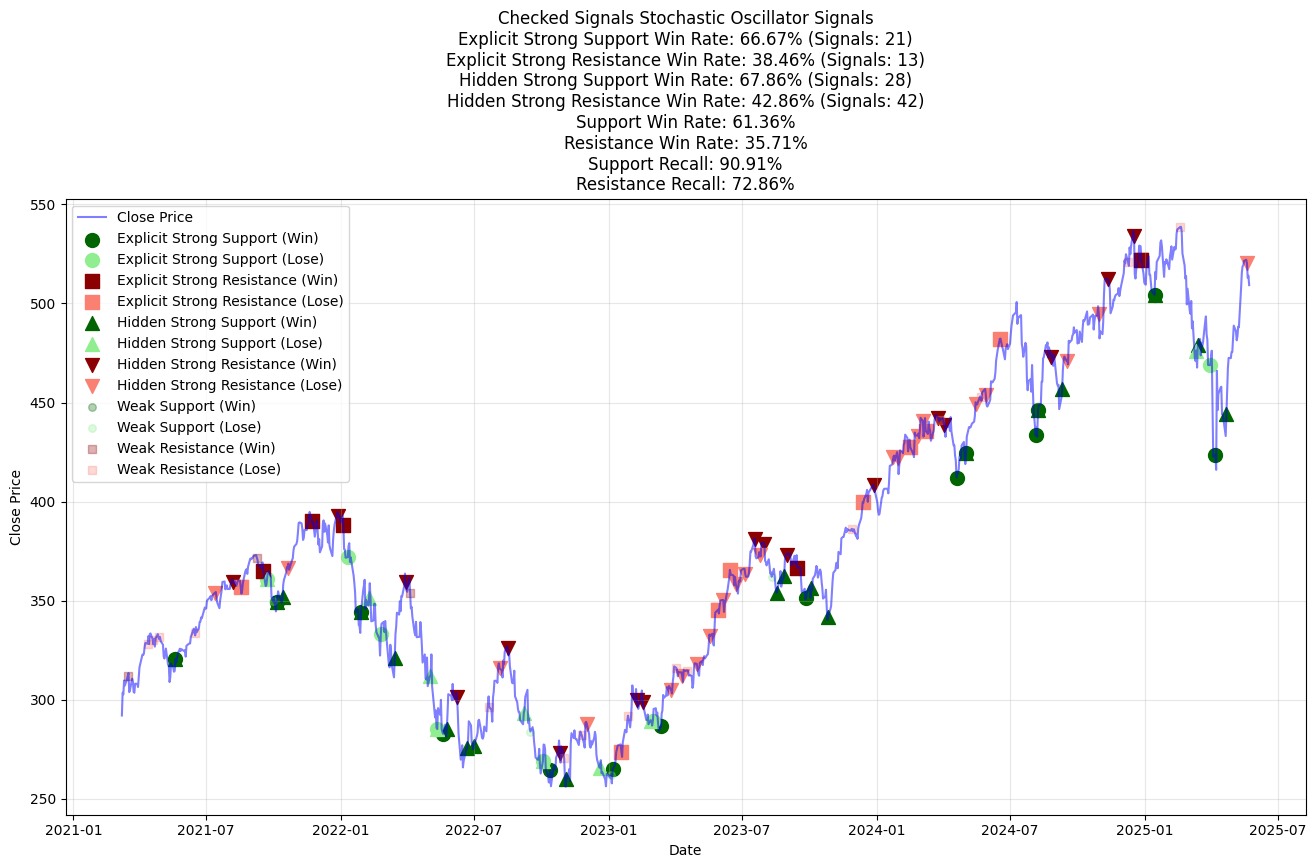

In [77]:
# 使用最佳参数计算最终信号
df = detect_stochastic_signals_origin(df,mode='eval', **best_params)
# df = detect_stochastic_signals(df,mode='eval', **best_params)
result = calculate_win_rate(df)

# 输出结果
# display(df_states.tail(12))
print(f"Support Reversal for {csv_filename}:")
print(f"Current Market State: {current_state['Period']}")
print(f"Current Market State Volatility: {current_state['Historical_Volatility']}")
print(f"Current Market signal target percentage: {signal_target_percentage*100}%")
print(f"Recommended look_ahead for {current_state['Period']}: {currnet_look_ahead} days")
print(f"Pre-calculated: look_ahead={look_ahead}, target_multiplier={target_multiplier:.2f}, atr_period={atr_period}")
print(f"Best Parameters: {best_params}")
print(f"Overall Support Reversal Win Rate: {result['support_win_rate']:.2%} (Signals: {result['support_signals_count']})")
print(f"Overall Resistance Reversal Win Rate: {result['resistance_win_rate']:.2%} (Signals: {result['resistance_signals_count']})")
print(f"Strong Support Reversal Win Rate: {result['strong_support_win_rate']:.2%} (Signals: {result['strong_support_signals_count']})")
print(f"Strong Resistance Reversal Win Rate: {result['strong_resistance_win_rate']:.2%} (Signals: {result['strong_resistance_signals_count']})")
print(f"Explicit Strong Support Win Rate: {result['explicit_strong_support_win_rate']:.2%} (Signals: {result['explicit_strong_support_signals_count']})")
print(f"Explicit Strong Resistance Win Rate: {result['explicit_strong_resistance_win_rate']:.2%} (Signals: {result['explicit_strong_resistance_signals_count']})")
print(f"Hidden Strong Support Win Rate: {result['hidden_strong_support_win_rate']:.2%} (Signals: {result['hidden_strong_support_signals_count']})")
print(f"Hidden Strong Resistance Win Rate: {result['hidden_strong_resistance_win_rate']:.2%} (Signals: {result['hidden_strong_resistance_signals_count']})")
print(f"Support Recall: {result['support_recall']:.2%}")
print(f"Resistance Recall: {result['resistance_recall']:.2%}")


plot_signals(result,'Checked Signals')

Origin Signals

Support Reversal for orignal data_US_QQQ_20250525_K_DAY.csv:
Current Market State: 2025-05-23 00:00:00
Current Market State Volatility: 0.045405902672333624
Current Market signal target percentage: 5.0%
Recommended look_ahead for 2025-05-23 00:00:00: 10 days
Pre-calculated: look_ahead=10, target_multiplier=1.49, atr_period=35
Best Parameters: {'k_period': 20, 'd_period': 3, 'overbought': 50.0, 'oversold': 50.0, 'ma_period': 30, 'atr_period_explicit': 50, 'atr_period_hidden': 5, 'strength_threshold': 1.0}
Overall Support Reversal Win Rate: 43.66% (Signals: 71)
Overall Resistance Reversal Win Rate: 22.31% (Signals: 130)
Strong Support Reversal Win Rate: 46.97% (Signals: 66)
Strong Resistance Reversal Win Rate: 30.23% (Signals: 86)
Explicit Strong Support Win Rate: 45.45% (Signals: 33)
Explicit Strong Resistance Win Rate: 29.63% (Signals: 27)
Hidden Strong Support Win Rate: 47.83% (Signals: 46)
Hidden Strong Resistance Win Rate: 30.30% (Signals: 66)
Support Recall: 92.96%
Resistance Recal

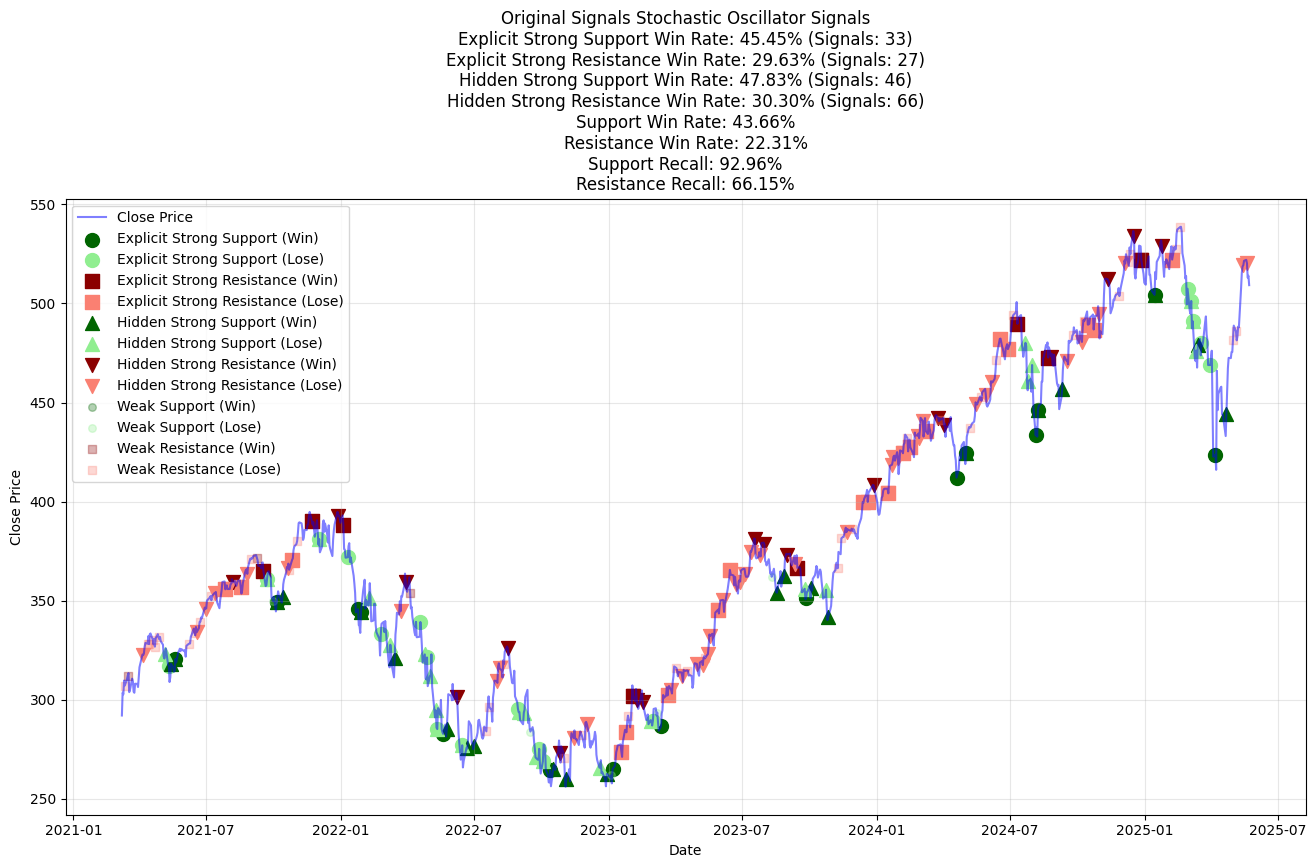

In [78]:
# 使用最佳参数计算最终信号
df_original = detect_stochastic_signals_origin(df,mode='train', **best_params)
# df_original = detect_stochastic_signals(df,mode='train', **best_params)
result_original = calculate_win_rate(df_original)

# 输出结果
# display(df_states.tail(12))
print(f"Support Reversal for orignal {csv_filename}:")
print(f"Current Market State: {current_state['Period']}")
print(f"Current Market State Volatility: {current_state['Volatility']}")
print(f"Current Market signal target percentage: {signal_target_percentage*100}%")
print(f"Recommended look_ahead for {current_state['Period']}: {currnet_look_ahead} days")
print(f"Pre-calculated: look_ahead={look_ahead}, target_multiplier={target_multiplier:.2f}, atr_period={atr_period}")
print(f"Best Parameters: {best_params}")
print(f"Overall Support Reversal Win Rate: {result_original['support_win_rate']:.2%} (Signals: {result_original['support_signals_count']})")
print(f"Overall Resistance Reversal Win Rate: {result_original['resistance_win_rate']:.2%} (Signals: {result_original['resistance_signals_count']})")
print(f"Strong Support Reversal Win Rate: {result_original['strong_support_win_rate']:.2%} (Signals: {result_original['strong_support_signals_count']})")
print(f"Strong Resistance Reversal Win Rate: {result_original['strong_resistance_win_rate']:.2%} (Signals: {result_original['strong_resistance_signals_count']})")
print(f"Explicit Strong Support Win Rate: {result_original['explicit_strong_support_win_rate']:.2%} (Signals: {result_original['explicit_strong_support_signals_count']})")
print(f"Explicit Strong Resistance Win Rate: {result_original['explicit_strong_resistance_win_rate']:.2%} (Signals: {result_original['explicit_strong_resistance_signals_count']})")
print(f"Hidden Strong Support Win Rate: {result_original['hidden_strong_support_win_rate']:.2%} (Signals: {result_original['hidden_strong_support_signals_count']})")
print(f"Hidden Strong Resistance Win Rate: {result_original['hidden_strong_resistance_win_rate']:.2%} (Signals: {result_original['hidden_strong_resistance_signals_count']})")
print(f"Support Recall: {result_original['support_recall']:.2%}")
print(f"Resistance Recall: {result_original['resistance_recall']:.2%}")
plot_signals(result_original,'Original Signals')

In [81]:
# 将原始DataFrame保存为CSV文件
# csv_path = '../data/stochastic_signals_optimized.csv'
# result_original['detailed_df'].to_csv(csv_path, index=True)
# print(f"\nDetailed DataFrame saved to: {csv_path}")